In [237]:
import numpy as np
import pandas as pd
import random
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import cebra
from cebra import CEBRA
import xgboost as xgb

from dataframe.csv_utils import (
    load_data_from_csv,
)
from data_utils import (
    load_data_from_dir,
)
from labels import get_behavioral_labels, get_raw_labels
from constants import AUDIO_BLOCKS
from feature_extraction import EEG_BANDS

data_dir = "../CleandDataV2/"
random.seed(33)

## Helper functions

In [ ]:
def get_categorical_labels(blocks, subject_data):
    behavioral_labels = []

    for b in blocks:
        block_data = subject_data[b]
        v_label = block_data.get_labels()
        a_label = block_data.get_labels("arousal")

        labels = [
            get_behavioral_labels(v_label[i], a_label[i]) for i in range(len(v_label))
        ]
        behavioral_labels.extend(labels)

    return behavioral_labels


def get_label_category(labels, label_type, v_thred, a_thred):
    threshold = a_thred if label_type == "arousal" else v_thred
    return [0 if p < threshold else 1 for p in labels]

## Load data and process features

In [113]:
# Read dictionary pkl file
with open('./eeg_features2/all_features.pkl', 'rb') as fp:
    marker_features = pickle.load(fp)
    print('Person dictionary')

with open('./data/ecg_features.pkl', 'rb') as fp:
    ecg_features = pickle.load(fp)
    ecg_features = ecg_features['ecg_features']

print(len(marker_features))

Person dictionary
41


In [ ]:
# Read labels pkl file
with open("./data/behavioral_labels.pkl", "rb") as fp:
    behavioral_labels = pickle.load(fp)

valence_labels, arousal_labels, attention_labels = (
    behavioral_labels["valence_labels"],
    behavioral_labels["arousal_labels"],
    behavioral_labels["attention_labels"],
)
print(len(valence_labels), len(valence_labels[0]))

In [414]:
import os

num_slice_per_trial = 5

subject_list = []
label_thresholds = []
idx = 0
for d in os.listdir(data_dir):
    dir_name = data_dir + d
    if not os.path.isdir(dir_name):
        continue
    
    vl, arl = valence_labels[idx], arousal_labels[idx]
    subject_list.append(d)
    label_thresholds.append((np.mean(vl), np.mean(arl)))
    idx += 1

### Slicing

In [437]:
import os
from features.feature_utils import get_feature_to_data
from features.constants import Feature

def _gst_std(data):
    data = np.array(data) # (4000)
    data_mean_across_channels = np.mean(data) # (1)
    p_sum = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        p_sum[i] = (data[i]-data_mean_across_channels)**2
    
    return np.sqrt(p_sum)

def _global_mean_field_power(data):
    data = np.array(data) # (128, 7)
    data_mean_across_channels = np.mean(data, axis=0) # (7)
    p_sum = np.zeros(data.shape[1])
    for i in range(data.shape[0]):
        p_sum = p_sum + (data[i]-data_mean_across_channels)**2
    
    return np.sqrt((p_sum/data.shape[0]))

def _get_eeg_psd_avg_band(block_data, srate: int, feature):
    from features.psd import get_psd, welch_bandpower

    psd_data = []
    num_trials = block_data.shape[0]
    # loop through all trials: time -> frequency
    for t in range(num_trials):
        all_channel_psd = []
        for i in range(block_data.shape[1]):
            #psd = get_psd(block_data[t, i, :], srate, EEG_BANDS[feature])
            freqs, psd = welch_bandpower(block_data[t, i, :], srate, None, 2)
            #psd = _gst_std(block_data[t, i, :])
            all_channel_psd.append(psd)
        
        #all_channel_psd = _global_mean_field_power(all_channel_psd)
        all_channel_psd = np.concatenate(all_channel_psd)
        psd_data.append(all_channel_psd)

    return np.stack(psd_data, axis=0)

def _get_raw_data_by_marker(subject_data, blocks, marker, feature):
    from resample.resample import (
        slice_data_by_seconds,
    )

    features = []
    for b in blocks:
        block_data = subject_data[b]
        srate =  block_data.get_srate(marker)
        sliced_data = slice_data_by_seconds(block_data.get_all_data()[marker], srate, 4)
        #psd_data = _get_eeg_psd_avg_band(sliced_data, srate, feature)
        psd_data = sliced_data[:, 0, :]
        #psd_data = slice_data_by_seconds(block_data.marker_to_data['ECG']['avgHR'].item(), srate, 4)[:,0,:]
        features = np.vstack((psd_data, features)) if len(features) > 0 else psd_data
    return features  

In [438]:
marker = "ECG"

subject_data_list = ['2012', '2013', '2029', '2031']
all_features = []
num_slice_per_trial = 5
valence_labels, arousal_labels, label_thresholds = [], [], []
for i, d in enumerate(os.listdir(data_dir)):
    # if d not in subject_data_list:
    #     continue

    dir_name = data_dir + d
    if not os.path.isdir(dir_name):
        continue

    subject_data = load_data_from_dir(dir_name)
    #features = get_feature_to_data(subject_data, AUDIO_BLOCKS, [Feature.RAW_DATA], marker)
    features = _get_raw_data_by_marker(subject_data, AUDIO_BLOCKS, marker, Feature.DELTA)
    all_features.append(features)
    vl, arl, _ = get_raw_labels(AUDIO_BLOCKS, subject_data, num_slice_per_trial)
    valence_labels.append(vl)
    arousal_labels.append(arl)
    label_thresholds.append((np.mean(vl), np.mean(arl)))
    # across_blocks_label_thresholds.append(get_label_means(subject_data))

Loading ../CleandDataV2/2040 data...
Loading ../CleandDataV2/2013 data...
Loading ../CleandDataV2/2022 data...
Loading ../CleandDataV2/2025 data...
Loading ../CleandDataV2/2046 data...
Loading ../CleandDataV2/2041 data...
Loading ../CleandDataV2/2024 data...
Loading ../CleandDataV2/2012 data...
Loading ../CleandDataV2/2037 data...
Loading ../CleandDataV2/2001 data...
Loading ../CleandDataV2/2039 data...
Loading ../CleandDataV2/2006 data...
Loading ../CleandDataV2/2038 data...
Loading ../CleandDataV2/2007 data...
Loading ../CleandDataV2/2000 data...
Loading ../CleandDataV2/2009 data...
Loading ../CleandDataV2/2036 data...
Loading ../CleandDataV2/2031 data...
Loading ../CleandDataV2/2017 data...
Loading ../CleandDataV2/2028 data...
Loading ../CleandDataV2/2010 data...
Loading ../CleandDataV2/2026 data...
Loading ../CleandDataV2/2019 data...
Loading ../CleandDataV2/2021 data...
Loading ../CleandDataV2/2044 data...
Loading ../CleandDataV2/2043 data...
Loading ../CleandDataV2/2020 data...
L

In [439]:
channel_name = marker + ''
feature_name = Feature.RAW_DATA.name

marker_features = []
for data in all_features:
    marker_features.append({channel_name: {feature_name: data}})
marker_features[0][channel_name][feature_name].shape

(260, 2000)

In [ ]:
# with open(f'data/avghr_ecg_features.pkl', 'wb') as handle:
#     d = {'avghr_ecg_features': ecg_features}
#     pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Model Training

### Dataset utils

In [182]:
from plotting import plot_roc_curve
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score

# from importlib import reload
# import features.constants

# reload(features.constants)
from features.constants import Feature

def get_all_spectral_features(feature_to_data: dict):
    all_spetral_psd = [feature_to_data[f.name] for f in EEG_BANDS.keys()]
    all_spetral_psd = np.hstack(all_spetral_psd)
    return all_spetral_psd

def get_all_channel_features_by_bands(data: dict, eeg_bands):
    all_spetral_psd = []
    for _, feature_to_data in data.items():
        spetral_psd = [feature_to_data[f.name] for f in eeg_bands]
        all_spetral_psd.extend(spetral_psd)

    all_spetral_psd = np.hstack(all_spetral_psd)
    return all_spetral_psd

def prepare_eeg_data(data, has_all_spectral, filtered_channel):
    data_dict = {} 
    if filtered_channel == "ALL":
        data_dict= {filtered_channel: {}}
        for f in EEG_BANDS.keys():
            data_dict[filtered_channel][f.name] = get_all_channel_features_by_bands(
                data,[f]
            )

        data_dict[filtered_channel][
            Feature.ALL_SPECTRAL.name
        ] = get_all_channel_features_by_bands(
            data, list(EEG_BANDS.keys())
        )

        return data_dict

    data_dict = {}
    for channel, feature_to_data in data.items():
        if channel != filtered_channel and len(filtered_channel) > 0:
            continue
        
        data_dict[channel] = {}
        if has_all_spectral:
            data_dict[channel][Feature.ALL_SPECTRAL.name] = get_all_spectral_features(
                feature_to_data
            )
            continue

        for f, neural_data in feature_to_data.items():
            # Prepare the data
            data_dict[channel][f] = neural_data
    
    return data_dict
    
def prepare_dataset(
    data,
    ecg_data,
    dataset_builder,
    labels,
    has_all_spectral: bool = False,
    filtered_channel: str = "",
):  
    
    data_dict = prepare_eeg_data(data, has_all_spectral, filtered_channel)
    # Combine with ecg...
    dataset_dict = {k: {} for k in data_dict.keys()}
    for k, feature_to_data in data_dict.items():
        for f, fd in feature_to_data.items():
            dataset_dict[k][f] = dataset_builder.train_test_split(fd, ecg_data, labels)
    return dataset_dict

### Training utils

In [240]:
from model.embedding import get_embeddings
from sklearn.preprocessing import StandardScaler

# CEBRA hyper-parameters
OUTPUT_DIM = 8 #64
MAX_HIDDEN_UNITS = 256
KNN_DECODER_NEIGHBOR = 8

# output_dim, max_hidden_units only needed for CEBRA
def run_knn_decoder(
    dataset,
    method,
    threshold,
    output_dim,
    max_iteration,
    n_neighbors: int = KNN_DECODER_NEIGHBOR,
):
    y_pred, y_pred_cat, all_embeddings = [], [], []
    for _, (train_data, train_labels, val_data, _) in enumerate(dataset):
        embedding, val_embedding = [], []
        # The first data is eeg and then ecg...
        for idx, td in enumerate(train_data):
            if idx == 1:
                continue
            e, ve = get_embeddings(
                train_data=td,
                val_data=val_data[idx],
                train_labels=train_labels,
                use_pca=(method == "PCA"),
                out_dim= 6 if method == "PCA" else output_dim,
                num_hidden_units=MAX_HIDDEN_UNITS,
                max_iterations=max_iteration,
            )
            embedding.append(e)
            val_embedding.append(ve)
        # 2. Concat eeg and ecg data
        embedding = np.hstack(embedding)
        val_embedding = np.hstack(val_embedding)
        
        all_embeddings.append((embedding, val_embedding))
        # 3. normalize eeg and ecg data
        standard_scaler = StandardScaler()
        X_train_standard = standard_scaler.fit_transform(embedding)
        X_test_standard = standard_scaler.transform(val_embedding)
        # 4. Train the decoder on training embedding and labels
        #decoder = xgb.XGBRegressor(verbosity=0)
        decoder = cebra.KNNDecoder(n_neighbors=n_neighbors, metric="cosine")
        decoder.fit(X_train_standard, np.array(train_labels))

        # score = decoder.score(val_embedding, np.array(val_labels))
        prediction = decoder.predict(X_test_standard)
        y_pred.append(prediction)
        y_pred_cat.append([0 if p < threshold else 1 for p in prediction])

    return y_pred, y_pred_cat, all_embeddings

def decode_marker_data(
    dataset_dict,
    label_type,
    v_thred,
    a_thred,
    method,
    threshold,
    max_iteration,
    plot_roc: bool = False,
):
    f1_score_data = {k: {} for k in dataset_dict.keys()}
    accuracy = {k: {} for k in dataset_dict.keys()}
    list_embedding_tuple = []
    for channel, feature_to_data in dataset_dict.items():
        if len(feature_to_data) == 0:
            continue

        for f, dataset in feature_to_data.items():
            val_true_cat = [
                get_label_category(val_labels, label_type, v_thred, a_thred)
                for _, (_, _, _, val_labels) in enumerate(dataset)
            ]

            y_pred, val_pred_cat, all_embeddings = run_knn_decoder(
                dataset,
                method,
                threshold,
                OUTPUT_DIM,
                max_iteration,
            )

            if plot_roc:
                plot_roc_curve(y_pred, val_true_cat, method, label_type, channel, f)

            score = [
                f1_score(y_pred=val_pred_cat[i], y_true=val_true_cat[i])
                for i in range(len(val_pred_cat))
            ]
            ac_scores = [
                accuracy_score(y_pred=val_pred_cat[i], y_true=val_true_cat[i])
                for i in range(len(val_pred_cat))
            ]

            max_score_index = np.array(ac_scores).argmax(axis=0)
            mean_acc = round(np.mean(ac_scores),2) 
            max_acc = round(ac_scores[max_score_index], 2)
            list_embedding_tuple.append(
                (
                    f"CV Acc Max: {max_acc} Avg:{mean_acc}",
                    max_score_index,
                    all_embeddings[max_score_index],
                    (dataset[max_score_index][1], dataset[max_score_index][3]),
                )
            )

            f1_score_data[channel][f] = np.mean(score)
            accuracy[channel][f] = np.mean(ac_scores)
       
    return list_embedding_tuple, accuracy

### Cross Validation

In [263]:
from resample.resample import get_consecutive_validation_indexes

n_step_trial = 3
val_indexes = [
    get_consecutive_validation_indexes(
        len(valence_labels[0]), len(AUDIO_BLOCKS), num_slice_per_trial, i, n_step_trial
    )
    for i in range(1, 13, n_step_trial)
]
print(len(val_indexes), val_indexes)

4 [[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229], [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 180, 181, 182, 183, 184, 185, 186, 

### Get subjects summary

In [264]:
from model.dataset import DatasetBuilder

dataset_builder = DatasetBuilder(len(valence_labels[0]), val_indexes_group=val_indexes)
shuffled_indexes = dataset_builder.get_shuffled_indexes()

In [447]:
def get_metadata(accuracy: dict):
    all_channels, all_feature_name, mean_scores = [], [], []
    for k, v in accuracy.items():
        for f, score in v.items():
            mean_scores.append(score)
            all_channels.append(k)
            all_feature_name.append(f)

    return all_channels, all_feature_name, mean_scores


subject_accuracy_summary = {
    "subject": [],
    "channel": [],
    'feature': [],
    "label_type": [],
    "cv_mean_score": [],
}

###CHANGE ME####
method = 'CEBRA'
filtered_channel = ""
combined_all_spectral = False
plot_roc = False

MAX_ITERATION = 100
# marker_features = all_features # raw data
subject_list = subject_list
###############

subject_to_embedding = { s: {'valence': [], 'arousal': []} for s in subject_list}

for idx in range(len(subject_list)):
    subj = subject_list[idx]
    print('decoding subject...', subj)

    v_thred, a_thred = label_thresholds[idx]
    for lt in ["valence", "arousal"]:
        labels = valence_labels[idx] if lt == "valence" else arousal_labels[idx]
        thred = v_thred if lt == "valence" else a_thred

        dataset_dict = prepare_dataset(
            marker_features[idx],
            [],
            dataset_builder,
            labels,
            combined_all_spectral,
            filtered_channel,
        )

        subject_to_embedding[subj][lt], accuracy = decode_marker_data(
            dataset_dict, lt, v_thred, a_thred, method, thred, MAX_ITERATION, plot_roc
        )

        all_channels, all_feature_name, mean_scores = get_metadata(accuracy)

        subject_accuracy_summary["subject"].extend(
            [subj] * len(all_feature_name)
        )
        subject_accuracy_summary["channel"].extend(all_channels)
        subject_accuracy_summary["feature"].extend(all_feature_name)
        subject_accuracy_summary["cv_mean_score"].extend(mean_scores)
        subject_accuracy_summary["label_type"].extend([lt] * len(all_feature_name))

subject_accuracy_summary = pd.DataFrame(subject_accuracy_summary)
subject_accuracy_summary["subject"] = subject_accuracy_summary["subject"].astype(int)

decoding subject... 2040
decoding subject... 2013
decoding subject... 2022
decoding subject... 2025
decoding subject... 2046
decoding subject... 2041
decoding subject... 2024
decoding subject... 2012
decoding subject... 2037
decoding subject... 2001
decoding subject... 2039
decoding subject... 2006
decoding subject... 2038
decoding subject... 2007
decoding subject... 2000
decoding subject... 2009
decoding subject... 2036
decoding subject... 2031
decoding subject... 2017
decoding subject... 2028
decoding subject... 2010
decoding subject... 2026
decoding subject... 2019
decoding subject... 2021
decoding subject... 2044
decoding subject... 2043
decoding subject... 2020
decoding subject... 2018
decoding subject... 2011
decoding subject... 2016
decoding subject... 2029
decoding subject... 2042
decoding subject... 2045
decoding subject... 2034
decoding subject... 2033
decoding subject... 2005
decoding subject... 2002
decoding subject... 2003
decoding subject... 2004
decoding subject... 2032


In [448]:
print(subject_accuracy_summary[subject_accuracy_summary.label_type =='valence']['cv_mean_score'].mean())
print(subject_accuracy_summary[subject_accuracy_summary.label_type =='arousal']['cv_mean_score'].mean())
subject_accuracy_summary.head()

0.5122967479674797
0.5157520325203252


,subject,channel,feature,label_type,cv_mean_score
0,2040,ECG,RAW_DATA,valence,0.525000
1,2040,ECG,RAW_DATA,arousal,0.550000
2,2013,ECG,RAW_DATA,valence,0.483333
3,2013,ECG,RAW_DATA,arousal,0.562500
4,2022,ECG,RAW_DATA,valence,0.479167


In [449]:
identifier = f'{MAX_ITERATION}iter_ecg_raw'
identifier

'100iter_ecg_raw'

In [444]:
with open(f'results/models/{method}_{identifier}_embeddings.pkl', 'wb') as handle:
    pickle.dump(subject_to_embedding, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [450]:
subject_accuracy_summary["channel"] = subject_accuracy_summary["channel"].astype(str)
subject_accuracy_summary.to_csv(f'results/{method}_{identifier}.csv')

## Plot CV mean score

Text(0.5, 0.98, 'ECG- 100 iter')

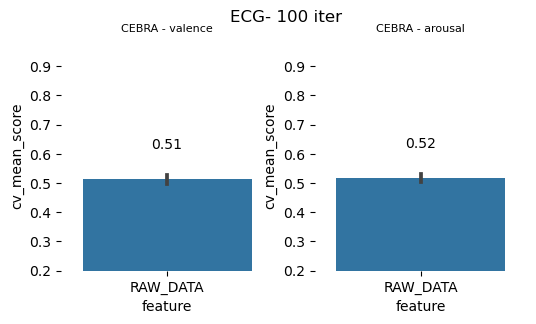

In [451]:
n_row, n_col = (1,2) #(4, 8)
fig, axes = plt.subplots(
    nrows=n_row,
    sharey=False,
    ncols=n_col,
    figsize=(n_col * 3, n_row * 3),
)

for idx, label_type in enumerate(['valence', 'arousal']):
    d = subject_accuracy_summary[(subject_accuracy_summary['label_type'] == label_type)]
    ax = sns.barplot(d, x="feature", y="cv_mean_score", ax=axes.flat[idx], units='subject')
    #ax = sns.boxplot(d, x="channel", y="cv_mean_score", hue='feature', ax=axes.flat[idx])

    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f', padding=20)  
    
    #ax.get_legend().set_visible(idx == 1)
    ax.set_title(f'{method} - {label_type}', size=8)
    ax.set(ylim=(0.2, 0.99))
sns.despine(bottom = True, left = True)
fig.suptitle(f'{marker}- {MAX_ITERATION} iter')

/Users/ccnlab/miniconda3/envs/MM/lib/python3.8/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


Text(0.5, 1.0, ' channel spectral - CEBRA ')

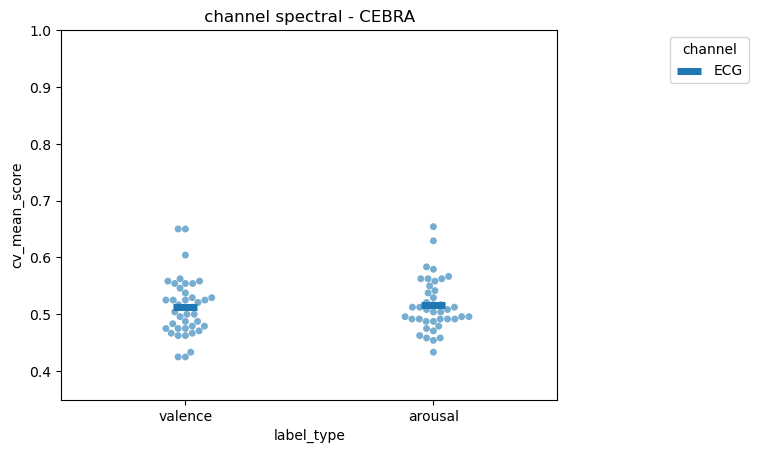

In [452]:
data = subject_accuracy_summary
title = f"{filtered_channel} channel spectral - {method} "  #
g = sns.swarmplot(
    data=data,
    x="label_type",
    y="cv_mean_score",
    hue="channel",
    # hue_order=[
    #     "DELTA",
    #     "THETA",
    #     "ALPHA",
    #     "BETA1",
    #     "BETA2",
    #     "GAMMA",
    #     'ALL_SPECTRAL',
    # ],    
    alpha=0.6,
    dodge=True,
    legend=False,
)
g.set_ylim((0.35, 1))

df_means = (
    data.groupby(["label_type", "channel"])["cv_mean_score"].agg("mean").reset_index()
)
pp = sns.pointplot(
    x="label_type",
    y="cv_mean_score",
    data=df_means,
    hue="channel",
    dodge=0.6,
    linestyles="",
    errorbar=None,
    scale=2.5,
    markers="_",
    # hue_order=[
    #     "DELTA",
    #     "THETA",
    #     "ALPHA",
    #     "BETA1",
    #     "BETA2",
    #     "GAMMA",
    #     'ALL_SPECTRAL',
    # ],
    order=["valence", "arousal"],
)

sns.move_legend(pp, "upper right", bbox_to_anchor=(1.4, 1))
g.set_title(title)

## Plot embeddings

In [ ]:
colorMap = {'valence': '#94b325', 'arousal': '#595eeb'}
label_type = 'arousal'
best_embedding_idx = []

for i, s in enumerate(subject_list):
    (
        _,
        max_idx,
        (embeddings, val_embeddings),
        (embedding_labels, val_embedding_labels),
    ) = subject_to_embedding[s][label_type][0]
    abs_corr = []
    for idx in range(embeddings.shape[-1]):
        corr = np.corrcoef(embeddings[:, idx], embedding_labels)[0, 1]
        abs_corr.append(np.abs(corr))
    
    max_score_index = np.array(abs_corr).argmax(axis=0)
    best_embedding_idx.append(max_score_index)

n_row, n_col = (5, 8)
f, axarr = plt.subplots(n_row, n_col, figsize=(3 * n_col, 3 * n_row), sharey=True)
for idx, ax in enumerate(axarr.flat):
    s = subject_list[idx]
    l = f'L{best_embedding_idx[idx]}'
    (
        name,
        max_idx,
        (embeddings, val_embeddings),
        (embedding_labels, val_embedding_labels),
    ) = subject_to_embedding[s][label_type][0]

    result = pd.DataFrame({l: embeddings[:, best_embedding_idx[idx]], 'labels': embedding_labels})
    sns.regplot(data=result, ci=99, x=l, y='labels', color=colorMap[label_type], line_kws=dict(color="r"), ax=ax)    
    corr = np.corrcoef(result[l], embedding_labels)[0, 1]
    ax.text(
        0.1,
        0.95,
        "$r$ = {:.3f}".format(corr),
        horizontalalignment="left",
        verticalalignment="center",
        color='red',
        fontweight='heavy',
        transform=ax.transAxes,
        size=12,
    )    
    ax.set_title(f'{s}:{name}')
    ax.set(ylim=(0, 1))
f.tight_layout(pad=1.8)

## Attention investigation

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import math

test = np.array(attention_labels).ravel()
test = np.power(test, 1)
test = np.array(list(map(cutoff, test)))
scaler = MinMaxScaler(feature_range=(0, 1))
weights = scaler.fit_transform(test.reshape(-1, 1))

# Pass the NumPy array into the function


g = sns.histplot(
    data=mean_validation_score, stat="probability", cumulative=True
)
g.set_title("41 subjects attention rating in test")
g.axvline(np.mean(mean_validation_score), c="k", ls="-", lw=2.5)
g.axvline(np.median(mean_validation_score), c="orange", ls="--", lw=2.5)
g.set_ylim((0, 1))
g.set_xlim((0, 1))
#sns.displot(penguins, x="flipper_length_mm", kind="ecdf")

In [ ]:
# Define a  function to square elements
def cutoff(x):
    return math.pow(x, -2) if x > 50 else x

def nupsample_by_attention(attention, num_output):
    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler(feature_range=(0, 100))
    rating = np.array(attention).ravel()
    
    weights = scaler.fit_transform(np.power(rating, 1).reshape(-1, 1))
    weights = np.array(list(map(cutoff, weights.ravel())))

    resampled_features = random.choices(
        np.arange(0, len(attention), 1), weights=weights, k=num_output
    )

    return np.array(resampled_features)

def nget_resampled_list_index(train_indexes, attention_labels):
    # exclude validation
    train_attention_labels = np.array(attention_labels)[train_indexes]
    # up sample 4 times by attention labels
    resampled_list = nupsample_by_attention(
        train_attention_labels, len(train_attention_labels) * 4
    )
    return resampled_list

resampled_attention_list = []
for a in range(len(attention_labels)):
    for i in range(len(val_indexes)):
        train_indexes = list(set(range(len(attention_labels[a]))) - set(val_indexes[i]))
        resampled_list = nget_resampled_list_index(train_indexes, attention_labels[a])
        attention_list = np.array(attention_labels[a])[train_indexes][resampled_list]
        resampled_attention_list.append(attention_list.tolist())

In [ ]:
g = sns.histplot(
    data=np.array(resampled_attention_list).ravel(), stat="probability", cumulative=False
)
g.set_title("41 subjects w weighted attention distribution")
g.axvline(np.mean(np.array(resampled_attention_list)), c="k", ls="-", lw=2.5)
g.axvline(np.median(np.array(resampled_attention_list)), c="orange", ls="--", lw=2.5)
g.set_ylim((0, 0.2))
g.set_xlim((0, 1))

## MiSC: Loss/Grid search

In [ ]:
nrows = 1
ncols = len(loss_data)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    sharey=True,
    figsize=(ncols * 5, nrows * 5),
)

fig.suptitle(
    f"Subject {subj}: {marker} {label_type} InfoNCE loss in audio condition",
    fontsize=15,
)

for c, ax in zip(loss_data.keys(), axes.flatten()):
    df = pd.DataFrame(loss_data[c])
    sns.lineplot(data=df, ax=ax)
    ax.set_title("channel:" + c)
    ax.set_ylabel("InfoNCE Loss")
    ax.set_xlabel("Steps")
# plt.savefig(f"results/cebra/{label_type}_{subj}_eeg_bands_channel_loss_{channel}_O{output_dim}H{max_hidden_units}.png")